## Statistical analysis of GaInP/GaAs photocathodes from multiple growths and across each growth

**Authors:**
> Olivia Alley, (oalley@lbl.gov), [github](https://github.com/oliviaalley)  
> Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)



**Resources**  
* Package `eclabfiles` reads files written by EC-Lab, installed with `pip install eclabfiles` 
  * [link](https://pypi.org/project/eclabfiles/), version 0.4.1 - it was not on `pypi` at one point but now it is...
  * Also, it requires `python` version >= 3.9

## Analysis 1:  
### Box plots for 2 electrode results for each of 8 growths with Jsat, V(5mA), and Jsc. Compare this with box plot for entire data set of 54 electrodes over 8 growths.

> Area of each electrode = 0.2 cm2  
> What materials were each? what were the parameters changed between growth? i.e. capping layer  
> Total number of 2 electrode cuvette results at pH 0.4: 54  
> Total number of MOVPE growths represented: 8  
> Between 2 and 10 electrodes per wafer

## Import eclab LSV files and extract data and metadata

Imports all columns of each eclab file using the ecf.process method.  
The eclabfiles parser may not still be maintained as of 2022.
    
>.mpr files will be used here.
All cuvette data was collected in 30-305 and under 1 sun illumination--therefore there is no need to accomodate .mpt files, which are needed for analysis of 30-107 data.

>Some options for values to calculate incldude the 2-electrode saturation photocurrent (Jsat) or zero bias photocurrent (Jsc), and the applied potential for 5 mA/cm2 current density.

   **File naming convention:**

        LSV files: WB832-1_0pt5MH2SO4_3e-1_LSV.mpr
        During acquisition can add as comments additional metadata

        Surface area file: SA.xlsx
        
note WB832-1r is a repeat measurement of the same electrode

In [2]:
# file handling
import os
import eclabfiles as ecf

# data analysis
import pandas as pd
import numpy as np
import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Generate file and sample lists

In [7]:
# Collect all files and iterate through them, making a list of their names for later reference

# change directory_in_str to match where the .mpr files are
directory_in_str = './H2SO4 electrolyte/2e'
filename_list = []
electrode_list = []

# This function generates a byte string, which can be referenced like a list
# each character except for quotes becomes a value. This function uses UTF-8 encoding to generate the bytes.
directory = os.fsencode(directory_in_str)

# generate list of full names and of their prefix prior to the first '_'
# from naming convention, prefix is electrode name, for example WB832-5.
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".mpr"):
        filename_list.append(filename)
        #print(format(filename))
        name,ext = os.path.splitext(filename)
        #print(name)
        # add the filename to a list
        electrode_list.append(name.split('_', maxsplit=1)[0])
        #print(name[:7])
        continue
     else:
         continue

# read in the SA.xlsx file in the electrolyte folder
# could use concat to merge df_SA and the two lists above on 'Electrode' to facilitate accessing SA later
df_SA = pd.read_excel('./H2SO4 electrolyte/SA.xlsx')
#print("Electrode surface areas from file:\n", df_SA.head())

# read in the growth details file in the main folder
df_growth = pd.read_excel('./NREL_growths.xlsx', usecols=('A,B,D,F,G'))
df_growth.rename(columns={'Run Name': 'Growth', 'Date': 'G_Date', 'Top cell base thickness (um)': 'TCBT_um', 'Cap thickness (nm)': 'Cap_nm'}, inplace=True)
df_growth.head()
print("\nIII-V growth details:\n", df_growth.head())
print("\ncapping material:\n", df_growth['Cap'])

            
# <40 to get a minimum length of 40 and left justified. {"*"*60} to add a row of *
print("\nList of all files loaded here:")
print(f'{"Filename":<40}\tElectrode\n{"*"*60}')
for filename, electrode in zip(filename_list, electrode_list):
    print(f'{filename:<40}\t{electrode}')


III-V growth details:
   Growth     G_Date  TCBT_um    Cap  Cap_nm
0  WB832 2021-03-10     0.90  GaInP      15
1  WB909 2021-04-27     0.45  GaInP      15
2  WB964 2021-05-27     0.45  GaInP      15
3  WC009 2021-06-29     0.45  GaInP      15
4  WC106 2021-09-13     0.45  GaInP      15

capping material:
 0     GaInP
1     GaInP
2     GaInP
3     GaInP
4     GaInP
5     GaInP
6     GaInP
7       GaP
8       GaP
9       GaP
10      GaP
Name: Cap, dtype: object

List of all files loaded here:
Filename                                	Electrode
************************************************************
WB832-C2_0pt5MH2SO4_2e_LSV.mpr          	WB832-C2
WC134-6_0pt5MH2SO4_2e_LSV.mpr           	WC134-6
WB832-NREL2_0pt5MH2SO4_2e_LSV.mpr       	WB832-NREL2
WB964-6_0pt5MH2SO4_2e_LSV.mpr           	WB964-6
WC213-4_0pt5MH2SO4_2e_LSV.mpr           	WC213-4
WB909-6_0pt5MH2SO4_2e_LSV.mpr           	WB909-6
WC109-8_0pt5MH2SO4_2e_LSV.mpr           	WC109-8
WC009-7_0pt5MH2SO4_2e_LSV.mpr           	WC

# Define the functions to operate on the data

In [4]:
# Edit the column names based on those needed for analysis
# no longer used
#def column_edit(df):
    """
    Can select desired columns depending on the experiment.
    Input: a dataframe from eclabfiles.read
    Output: None, acts in place on the input
    """
    # drop the columns you don't want
#    df.drop(['time', '(Q-Qo)', 'I Range', 'mode', 'ox/red', 'error', 'control changes', 'uts'], axis=1, inplace=True)
    # rename the columns you do want
 #   df.rename(columns={'control_V': 'Control (V)', 'Ewe': 'Ewe (V vs. CE)', '<I>': 'I (mA)'}, inplace=True)
    #print("column_edit:", df.head(1))
    
# Find the surface area for each sample in the surface area file, and use it to calculate the current density
def J_calc(df, electrode):
    """
    Inputs:
      dataframe from ec.to_df, string with the sample name
    Outputs
      None, acts in place on the dataframe
    """
    # Search df_SA for electrode to get the surface area in the row.
    name_index = df_SA.index[df_SA['Electrode'] == electrode]
    #print('the row is: \n', df_SA.iloc[name_index])
    #print('printing the value in the row with the right name: ', df_SA.iloc[name_index]['surface area (cm2)'].iloc[0])
    elec_SA = df_SA.iloc[name_index]['surface area (cm2)']
    #print('the surface area is: ', elec_SA.iloc[0])
  #  current_density = df['I (mA)'].div(0.25)
    current_density = df['I (mA)'].div(elec_SA.iloc[0])
    df['J (mA/cm2)'] = current_density
 #   print('after J_calc: \n', df.head(1))
    
def growth_lookup(growth):
    """
    Returns the needed values from the growth dataframe
    Input: a string representing the growth
    Output: a list containing numbers for top cell thickness, cap material, and cap thickness.
    """
    # first determine the index from df_growth that matches the growth of interest
    # then return the particular values of df_growth from that row
    growthdex = df_growth.index[df_growth['Growth'] == growth]
  #  df_all['TCBT'] = 
    TCBT = df_growth.iloc[growthdex]['TCBT_um'].values[0]
    Cap = df_growth.iloc[growthdex]['Cap'].values[0]
    Cap_thickness = df_growth.iloc[growthdex]['Cap_nm'].values[0]
    growth_date = df_growth.iloc[growthdex]['G_Date'].values[0]
    #Top cell base thickness (um)
    #print(Cap)
    #growthdex = df.index[df['Growth'] == growth]
    
    #print (growthdex)
    tokens = [TCBT, Cap, Cap_thickness, growth_date]
   # print(tokens)
    return tokens
    
    # Calculate the saturation current density and return it to the calling function
def Jsat_calc(df):
    """
    Calculates saturation current density assuming that corresponds to the most negative applied potential.
    Input:
     dataframe from ec.to_df
    Output:
     the saturation current density
    """
    mindex = df.index[df['Ewe (V vs. CE)'] == df['Ewe (V vs. CE)'].min()]
    sat_photocurrent = df.iloc[mindex]['J (mA/cm2)']
   # print("after Jsat_calc:", sat_photocurrent.iloc[0])
    return sat_photocurrent.iloc[0]

def Vonset(df, electrode):
    """
    calculate the lowest potential generating 5 mA/cm2 photocurrent.
    then find the most positive bias which is applied within that set.
    Input: data frame
    Output: The most positive potential at which current exceeds 0.1 mA
    """
    if df[df['J (mA/cm2)']<-0.1].empty:
        print(electrode, "has no photocurrent")
        return 0
    else:
        first_df = df[df['J (mA/cm2)']<-0.1]
        second_df = first_df[first_df['Control (V)'] == first_df['Control (V)'].max()]
    # The type of the single row df second_df is a Pandas series:
    # provide the value of the series in the Control (V) column.
        Vonset = second_df['Control (V)'].iloc[0]
        return Vonset
    
# Calculate the photocurrent at zero bias for two electrode LSVs
# Bias is never exactly zero: goes from -4.9314409E-004 V to 4.9910863E-004 V.
# Take average photocurrent of the points straddeling zero
# find index by looking for voltages greater than 0 and then subtract 1 from the first of them
def zero_bias(df, electrode):
    """
    Input: data frame
    Output: the short circuit current of the LSV in the data frame
    """
    # First, check if there is anything over zero. If not, sample failed, should enter 0 as zero bias current.
    #print('initial_df:', df.head())
    if df[df['Control (V)']>0].empty:
        print(electrode, "failed at zero V")
        return 0
    else:
        over_zero_df = df[df['Control (V)']>0]
        under_zero_df = df[df['Control (V)']<0]
        length = len(under_zero_df['Control (V)'])
    #    print("length:", length)
    #    print('under_zero_df:', under_zero_df.head())
    #    print("first J(mA/cm2) of over_zero:", over_zero_df.iloc[0]["J (mA/cm2)"])
   #     print("last J of under_zero:", under_zero_df.iloc[length-1]["J (mA/cm2)"])
        #under_zero_df.head(5)
        #zerodex = over_zero_df.tail(1).index
        #print("index for zero potential:", zerodex[0] - 1)
        #zero_bias_index = zerodex[0] - 1
        #print('first index for zero bias average:', zero_bias_index)
        #print(full_df)
        # Now just average the current density at the smallest positive and negative biases to approximate the bias at zero V
        Jsc = (under_zero_df.iloc[length-1]["J (mA/cm2)"] + over_zero_df.iloc[0]["J (mA/cm2)"])/2
        #Jsc = (df.iloc[zero_bias_index]['J (mA/cm2)'] + df.iloc[zero_bias_index - 1]['J (mA/cm2)'])/2
      #  print('The short circuit current density (mA/cm2) is: ', Jsc)
        return Jsc

# Calculate the lowest potential generating 5 mA/cm2 photocurrent.
def five_mA_pot(df, electrode):
    """
    calculate the lowest potential generating 5 mA/cm2 photocurrent.
    then find the most positive bias which is applied within that set.
    Input: a dataframe
    Output: float with the answer
    """
    if df[df['J (mA/cm2)']<-5].empty:
        print(electrode, "did not reach 5mA/cm2.")
        return 0
    else:
     #   print('whole df:', df.head())
        first_df = df[df['J (mA/cm2)']<-5]
     #   print('five mA calc first_df:', first_df.head())
    # what to do if first_df is empty?
        second_df = first_df[first_df['Control (V)'] == first_df['Control (V)'].max()]
    # The type of the single row df second_df is a Pandas series:
    #print(type(second_df['Control (V)']))
    # provide the value of the series in the Control (V) column.
        five_V = second_df['Control (V)'].iloc[0]
     #   print('The maximum potential (in V vs. CE) giving at least 5 mA/cm2 is: ' , five_V)
        return five_V

def row_del(df, row_list):
    """
    Intent is to facilitate plotting by removing first <int> rows
    Input: original LSV dataframe
    Output: acts in place on df
    """
    df.drop(row_list, inplace=True)
  #  print("with dropped rows:", df.head(1))

In [5]:
# Parse the prefix
# filename: WB832-1_0pt5MH2SO4_3e-1_LSV.mpr
def parse_filename(filename):
    """
    Parse the naming convention used by Olivia
    Input: prefix string
    Output: list with name of sample, experimental geometry, type of measurements
    """
    temp = filename.split('.')[0].split('_')
    growth = temp[0].split('-')[0]
    temp.append(growth)
    #print(temp)
    # Some crude error checking
    if len(temp) >= 5:
        tokens = temp[0:5]   #Truncate if too long
    elif len(temp) == 3:
        tokens = [temp[0], temp[1], temp[2], 'N/A']
    elif len(temp) == 2:
        tokens = [temp[0], temp[1], 'N/A', 'N/A']
    elif len(temp) == 1:
        tokens = [temp[0], 'N/A', 'N/A', 'N/A']
    else:
        tokens = ['N/A', 'N/A', 'N/A', 'N/A']
    return tokens

# Read files in and construct data object

In [6]:
exp_list = []

for filename in filename_list:     # Note that I am not using prefix_list
    """
    This loop generates a list of dictionarie
    The data (poential, current, etc.) is in dataframe called 'data'
     For the dataframe, using same column headings as Olivia
    Metadata, including sample name, is other (key, value) pairs
      Much more information could be added, e.g. time of measurement in date-time format
    """
    raw_data, meta = ecf.process(directory_in_str + '/' + filename)
    exp_list.append({"sample": parse_filename(filename)[0],
                     "electrolyte": parse_filename(filename)[1],
                     "geometry": parse_filename(filename)[2],
                     "measurement": parse_filename(filename)[3],
                     "growth": parse_filename(filename)[4],
                     # put the data of interest into a dataframe
                     "data": pd.DataFrame({'time': [dic['time'] for dic in raw_data],
                                          'Ewe (V vs. CE)':  [dic['Ewe'] for dic in raw_data],
                                           'Control (V)': [dic['control_V'] for dic in raw_data], 
                                          'I (mA)':  [dic['<I>'] for dic in raw_data]}),
                     'reference electrode': meta['settings']['reference_electrode'],
                     'dE/dt': meta['params'][0]['dE/dt'],
                     'full path': meta['log']['filename'],
                     'posix_timestamp': meta['log']['posix_timestamp'], 
                     # Can convert to date-time
                     "date": datetime.datetime.fromtimestamp(meta['log']['posix_timestamp']),
                     "meta": meta,
                     "raw_data": raw_data})


In [6]:
# Sort the list by sample
sort_helper = lambda dic: dic["sample"]   # Use a quick lambda function to extract sample. sort_helper takes in dic and returns dic["sample"]
# list.sort() has a key parameter to specify a function to be called on each list element prior to making comparisons
exp_list.sort(key=sort_helper)

growth_list = []
sample_list = []
for exp in exp_list:
  #  print("exp_list growths:", exp['growth'])
    growth_list.append(exp['growth'])
    sample_list.append(exp['sample'])
#print(set(growth_list))

# Run Olivia's functions and add columns to dataframe and (key, value) entries to the dictionary
for exp in exp_list:
    
    print("sample name:", parse_filename(filename)[0])
    print("sample name2:", exp["sample"])
    
    # Add and calculate a new column called "J (mA/cm2)" to the dataframe
    # the function changes each element of exp_list to include the new column
    J_calc(exp['data'], exp['sample'])
    
    # Remove first two data points to prevent plotting issue
    # this function acts on each element of exp_list, changing it
    row_del(exp['data'], [0,1])

    # Run Olivia's functions and add columns to dataframe and (key, value) entries to the dictionary
    # This one returns the saturation current density
    # I will add it to the dictionary
    # Jsat_calc will return the value of the saturation current density for this element of the exp_list.
    # This creates a new key in the exp_list[i] (where i = any list index) containing Jsat corresponding to each experiment
    # Let's see what difference assuming 0.25 cm2 surface area for every sample makes.
    exp["Jsat (mA/cm2)"] =  Jsat_calc(exp['data'])
    
    # J at zero bias, added to dictionary
    # creates a new key in exp_list[i] for zero bias current
    exp["zero bias"] =  zero_bias(exp['data'], exp['sample'])
    
    # V at 0.1 mA current density == onset potential
    # creates a new key in exp_list[i] for onset potential
    exp["onset potential"] = Vonset(exp['data'], exp['sample'])
 #   Vonset(df, electrode)

    # 5 mA potential, added to dictionary
    # creates a new key in exp_list[i] for potential at 5mA/cm2
    exp["5 mA potential"] =  five_mA_pot(exp['data'], exp['sample'])

    
# check that the right keys were created for one of the electrodes
# later make it a random electrode checked each time
print("exp_list keys:", exp_list[1].keys())

sample name: WC134-9
sample name2: WB832-C1
sample name: WC134-9
sample name2: WB832-C2
WB832-C2 failed at zero V
sample name: WC134-9
sample name2: WB832-C3
sample name: WC134-9
sample name2: WB832-C4
sample name: WC134-9
sample name2: WB832-C5
sample name: WC134-9
sample name2: WB832-C6
sample name: WC134-9
sample name2: WB832-C7
sample name: WC134-9
sample name2: WB832-C8
sample name: WC134-9
sample name2: WB832-C9
sample name: WC134-9
sample name2: WB832-NREL2
sample name: WC134-9
sample name2: WB832-NREL3
sample name: WC134-9
sample name2: WB832-NREL4
sample name: WC134-9
sample name2: WB832-NREL5
sample name: WC134-9
sample name2: WB832-NREL8
sample name: WC134-9
sample name2: WB909-1
WB909-1 failed at zero V
WB909-1 has no photocurrent
WB909-1 did not reach 5mA/cm2.
sample name: WC134-9
sample name2: WB909-2
sample name: WC134-9
sample name2: WB909-3
sample name: WC134-9
sample name2: WB909-4
sample name: WC134-9
sample name2: WB909-5
sample name: WC134-9
sample name2: WB909-6
s

In [7]:
print(exp_list[0].keys())

dict_keys(['sample', 'electrolyte', 'geometry', 'measurement', 'growth', 'data', 'reference electrode', 'dE/dt', 'full path', 'posix_timestamp', 'date', 'meta', 'raw_data', 'Jsat (mA/cm2)', 'zero bias', 'onset potential', '5 mA potential'])


In [8]:
# now, data is all added to data structure. 

In [9]:
# When were the measurements?

print('Sample        Measurement date and time')
for exp in exp_list:
    """
    The <10 in the format string makes a minimum length of 10 and left justifies
    """
    print(f"{exp['sample']:<15} {exp['date']:%Y-%m-%d %H:%M}" )

Sample        Measurement date and time
WB832-C1        2021-07-05 21:21
WB832-C2        2021-07-05 15:23
WB832-C3        2021-07-05 21:14
WB832-C4        2021-07-05 15:39
WB832-C5        2021-07-05 21:06
WB832-C6        2021-07-05 15:52
WB832-C7        2021-07-05 20:58
WB832-C8        2021-07-05 16:00
WB832-C9        2021-07-05 20:49
WB832-NREL2     2021-07-15 14:21
WB832-NREL3     2021-07-15 12:17
WB832-NREL4     2021-07-15 14:09
WB832-NREL5     2021-07-15 14:35
WB832-NREL8     2021-07-15 13:54
WB909-1         2021-07-19 12:33
WB909-2         2021-07-27 12:36
WB909-3         2021-07-19 13:01
WB909-4         2021-07-27 12:53
WB909-5         2021-07-23 11:30
WB909-6         2021-07-27 13:08
WB909-7         2021-07-23 11:47
WB964-10        2021-07-23 12:57
WB964-2         2021-07-23 12:32
WB964-4         2021-07-23 13:21
WB964-6         2021-07-23 12:13
WB964-8         2021-07-23 13:08
WC009-1         2021-11-09 17:06
WC009-2         2021-11-08 17:41
WC009-3         2021-11-09 17:31
WC0

# Plot LSVs

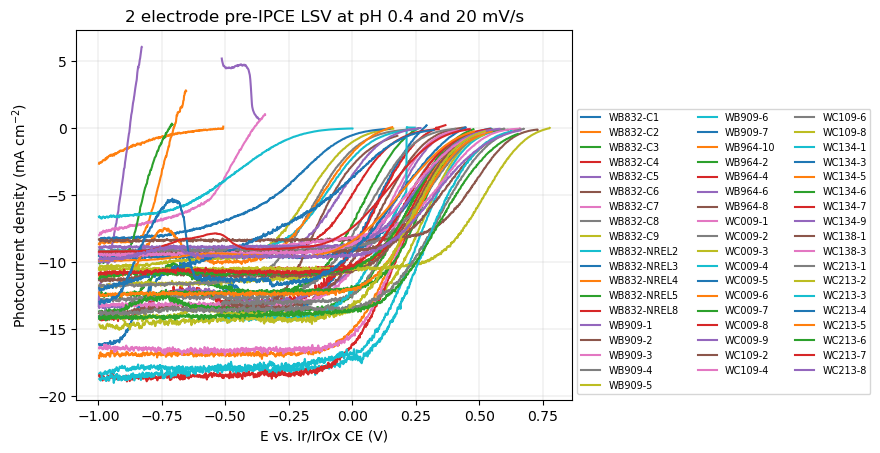

In [10]:
# Plot LSVs using matplotlib.pyplot

for dic in exp_list:
    # to plot with lines, delete first two data points, because otherwise values return to start.
    plt.plot(dic['data']['Ewe (V vs. CE)'], dic['data']["J (mA/cm2)"], '-', ms=1.5,  
             label=dic['sample'])
# Fancy, get the sweep rate from the metadata (assuming all were done at the same rate, which is a good assumption)
plt.title(f"2 electrode pre-IPCE LSV at pH 0.4 and {dic['dE/dt']:.0f} mV/s")
plt.xlabel(f"E vs. Ir/IrOx CE (V)")
plt.ylabel("Photocurrent density (mA cm$^{-2}$)")
plt.legend(bbox_to_anchor=(1, .8), ncol=3, fontsize=7)
plt.grid(lw=0.2)
plt.show()

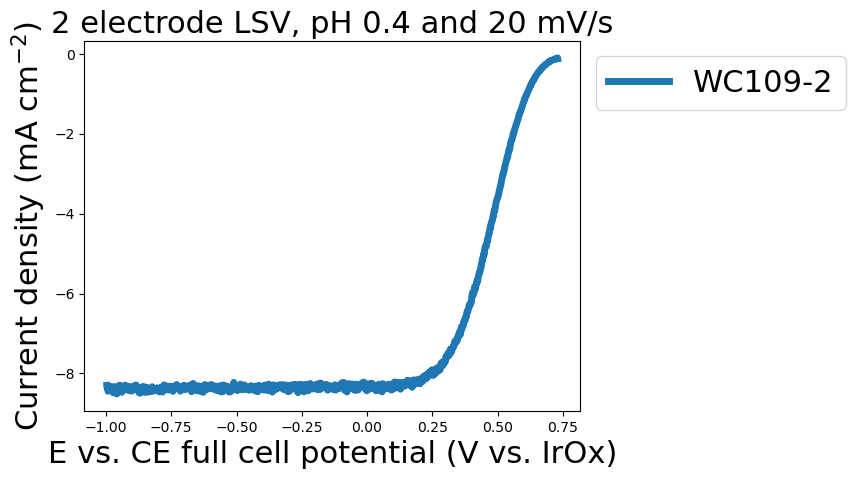

In [11]:
# plot just one for illustration
electrode = exp_list[-20]
num = electrode['sample']
#print(num)
plt.plot(electrode['data']['Ewe (V vs. CE)'], electrode['data']['J (mA/cm2)'], '-', ms=1.5, label=num, linewidth=5)
plt.title(f"2 electrode LSV, pH 0.4 and {dic['dE/dt']:.0f} mV/s", fontsize=22)
plt.xlabel(f"E vs. CE full cell potential (V vs. IrOx)", fontsize=22)
plt.ylabel("Current density (mA cm$^{-2}$)", fontsize=22)
plt.legend(bbox_to_anchor=(1,1), fontsize=22)
plt.show()

## LSV plotted for each growth
Title of each axes will be the growth. How to automate this? first count the number of growth values by one iteration, and give each axes a title and identity.  
 create a dataframe with growth, axes[i] values to refer to  
 legend will be the electrodes  
 can go back and plot on the same axes again? I think so  
 Iterate through exp_list.  

 now, have _growth_list_ and _set(growth_list)_, the latter which contains only the unique values of _exp_list['growth']_

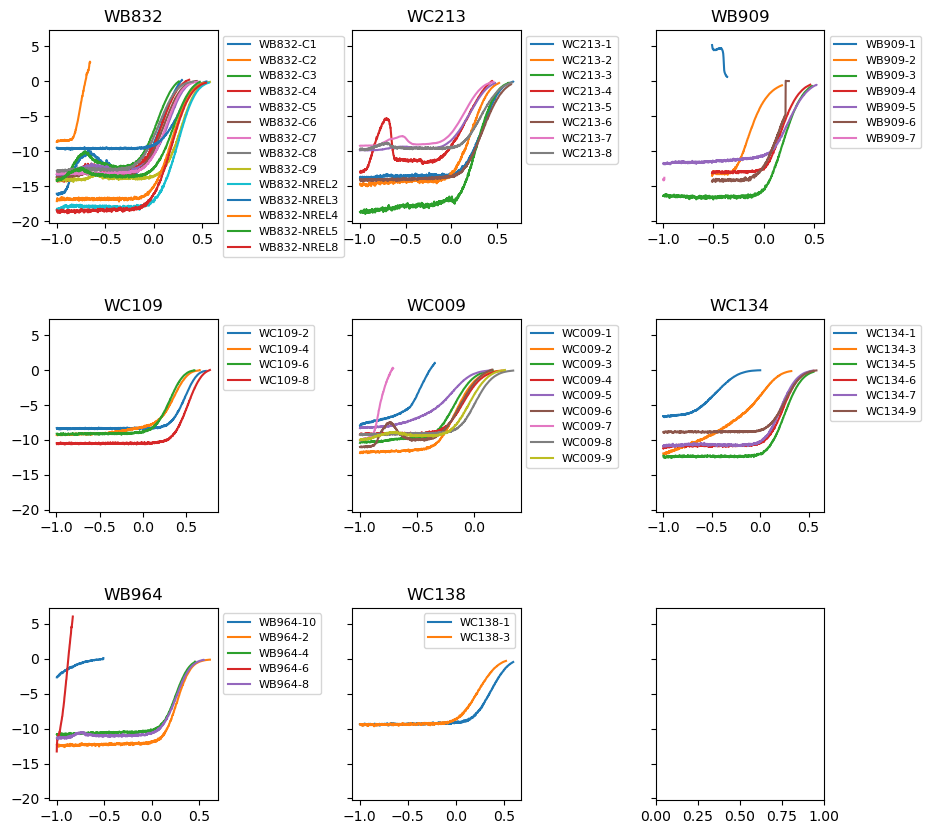

In [12]:
# create the figure
fig, ax = plt.subplots(nrows=3, ncols=3, sharey=True, dpi=100, figsize=(10, 10))
# make a list to refer to each element in the 3x3 plot array, because the axes is actually a list of 3 objects, each one being 3 axes in a list
ax_list = []
for a in ax:
    for i in range(0,3):
        ax_list.append(a[i])
# ax_list has 9 items, growth_list has only 8. There will be one empty plot.
for growth, axes in zip(set(growth_list), ax_list):
    # set the title of each axes as the particular growth
    axes.set_title(growth)
    # Now iterate through the experiment list and plot the electrodes corresponding to this growth.
    for exp in exp_list:
        if exp['growth']==growth:
            # it is from the same growth
            axes.plot(exp['data']['Ewe (V vs. CE)'], exp['data']['J (mA/cm2)'], '-', ms=1.5, 
                      label=exp['sample'])
            axes.legend(bbox_to_anchor=(1,1), fontsize=8, ncol=1)
        else:
            # from another growth
            continue

# add some white space
fig.subplots_adjust(wspace=.8, hspace=0.5)

plt.show()

## Display and statistical analysis of device parameters

### 1. Calculate the key metrics:
* saturation current density Jsat
* short circuit current density Jsc
* onset potential V_onset
* 5mA/cm2 potential V_5mA
### 2. Add in the growth parameters for the wafer
* capping layer material
* capping layer thickness
* top cell base thickness/TCBT
* growth date

In [13]:
# create empty lists with the key metrics
sample = []
growth = []
Jsat = []
Jsc = []
V_onset = []
V_5mA = []


# iterate through exp_list and fill each list
for exp in exp_list:
    """
    The <10 in the format string makes a minimum length of 10 and right justifies
    """
    sample.append(exp['sample'])
    growth.append(exp['growth'])
    Jsat.append(np.abs(exp['Jsat (mA/cm2)']))
    V_onset.append(np.abs(exp['onset potential']))
    Jsc.append(np.abs(exp['zero bias']))
    V_5mA.append(float(exp['5 mA potential']))

# create a dataframe, df_all, from the lists with the key metrics
df_all = pd.DataFrame({'Sample': sample,
                       'Growth': growth,
                       'Jsat (mA/cm2)': Jsat,
                       'Jsc (mA/cm2)': Jsc,
                       'V_onset': V_onset,
                       'V_5mA': V_5mA})

df_all

,Sample,Growth,Jsat (mA/cm2),Jsc (mA/cm2),V_onset,V_5mA
0,WB832-C1,WB832,16.157954,9.104689,0.274514,0.106404
1,WB832-C2,WB832,8.573917,0.000000,0.704958,-0.773122
2,WB832-C3,WB832,13.652918,7.169919,0.250526,0.057431
3,WB832-C4,WB832,14.090213,9.204426,0.320490,0.116999
4,WB832-C5,WB832,13.410872,10.437638,0.412439,0.179965
5,WB832-C6,WB832,13.803464,9.862762,0.392450,0.142985
6,WB832-C7,WB832,13.112378,10.556487,0.437426,0.166372
7,WB832-C8,WB832,12.873657,8.012504,0.381456,0.088714
8,WB832-C9,WB832,14.010306,13.677530,0.570354,0.321288
9,WB832-NREL2,WB832,18.260145,17.292124,0.571504,0.331283


In [14]:
# want to print out mean and std
df_describe = pd.DataFrame(df_all.describe())
df_describe.head()

,Jsat (mA/cm2),Jsc (mA/cm2),V_onset,V_5mA
count,55.000000,55.000000,55.000000,55.000000
mean,11.700294,8.009815,0.466037,0.073398
std,3.195484,5.111081,0.201877,0.346125
min,2.593686,0.000000,0.000000,-0.987256
25%,9.394340,3.133568,0.321594,-0.027463


In [15]:
# create empty lists for growth paramaters
TCBT = []
Cap = []
Cap_nm = []
growth_date = []

nrows=df_all.count()[0]

# append the new lists to df_all
for i in range(0,nrows):
    growth = df_all['Growth'][i]
    values_list = growth_lookup(growth)
    TCBT.append(values_list[0])
    Cap.append(values_list[1])
    Cap_nm.append(values_list[2])
    growth_date.append(values_list[3])

df_all['TCBT'] = TCBT
df_all['Cap'] = Cap
df_all['Cap_nm'] = Cap_nm
df_all['G_D'] = growth_date

df_all.head()

/var/folders/2y/4mhx_3j54gqb6nrcffc_37yh0000gn/T/ipykernel_45011/1811771970.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nrows=df_all.count()[0]


,Sample,Growth,Jsat (mA/cm2),Jsc (mA/cm2),V_onset,V_5mA,TCBT,Cap,Cap_nm,G_D
0,WB832-C1,WB832,16.157954,9.104689,0.274514,0.106404,0.9,GaInP,15,2021-03-10
1,WB832-C2,WB832,8.573917,0.000000,0.704958,-0.773122,0.9,GaInP,15,2021-03-10
2,WB832-C3,WB832,13.652918,7.169919,0.250526,0.057431,0.9,GaInP,15,2021-03-10
3,WB832-C4,WB832,14.090213,9.204426,0.320490,0.116999,0.9,GaInP,15,2021-03-10
4,WB832-C5,WB832,13.410872,10.437638,0.412439,0.179965,0.9,GaInP,15,2021-03-10


### Display histograms

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/s

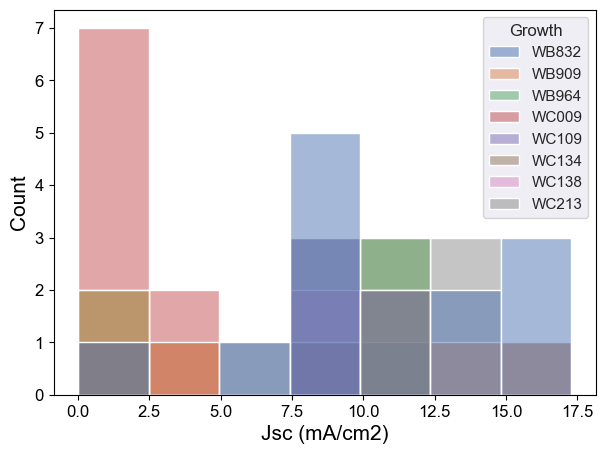

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(7,5))

sns.set_theme(color_codes=True)

sns.histplot(data=df_all, x='Jsc (mA/cm2)', hue="Growth", ax=ax)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Jsc (mA/cm2)', size=15)
ax.set_ylabel('Count', size=15)

#plt.legend(bbox_to_anchor=(1, .8), ncol=3, fontsize=7)

plt.show()

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/s

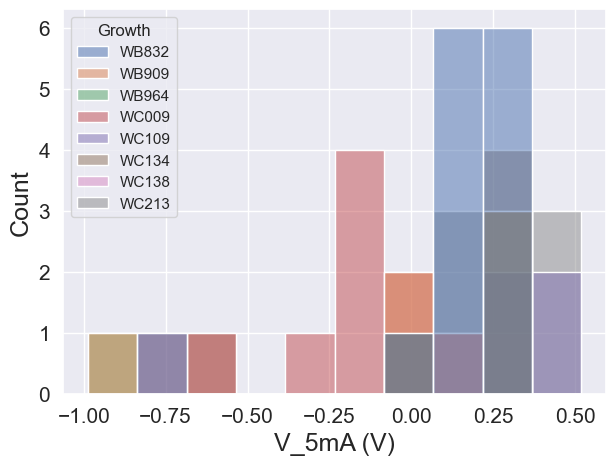

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(7,5))

sns.set_theme(color_codes=True)

sns.histplot(data=df_all, x='V_5mA', hue="Growth", ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('V_5mA (V)', size=18)
ax.set_ylabel('Count', size=18)

plt.show()

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/s

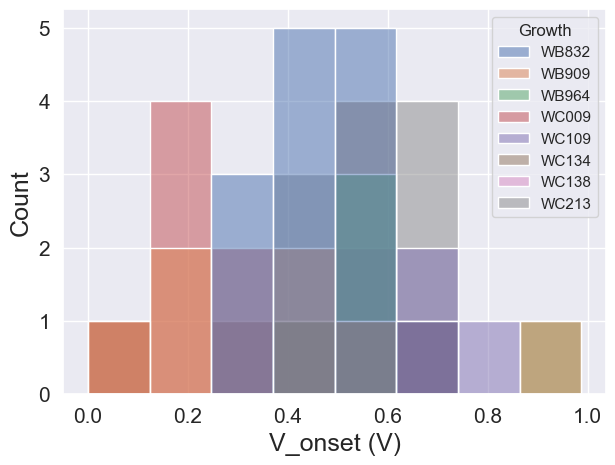

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(7,5))

sns.set_theme(color_codes=True)

sns.histplot(data=df_all, x='V_onset', hue="Growth", ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('V_onset (V)', size=18)
ax.set_ylabel('Count', size=18)

plt.show()

## Box plots of each growth vs. entire set

### Visually compare select parameters
 - Jsat, the current density at -1 V, the most negative measured potential, where curve has flattened out  
 - Jsc, the current density at 0 V  
 - V_5mA, the potential giving 5 mA/cm2 current denstiy  
 - V_onset, the onset potential, defined here as the potential giving 0.1 mA/cm2 current density**  

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

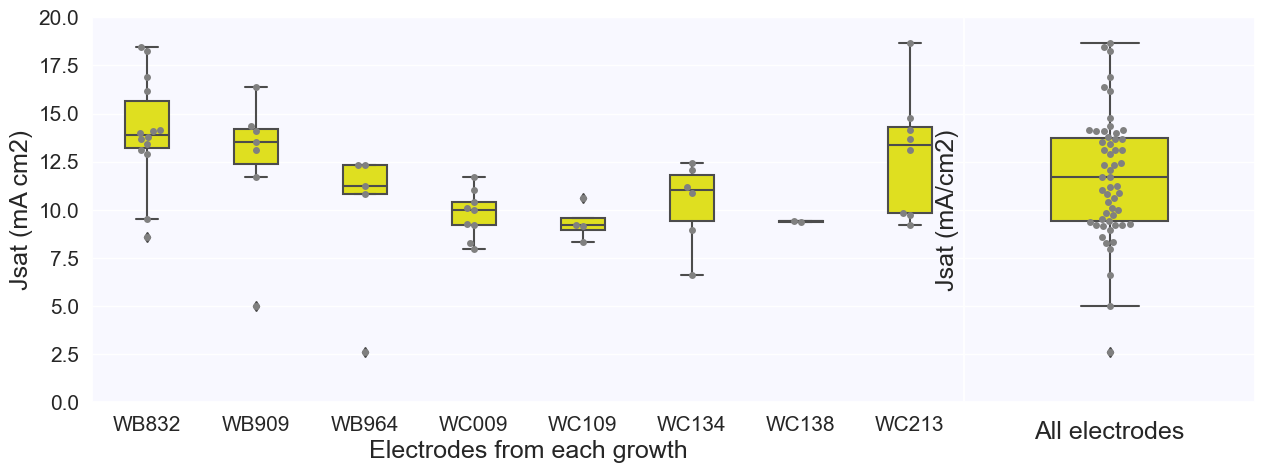

In [19]:
# Can divide it up by growth during the plotting process
# Box plots for Jsat

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='Jsat (mA/cm2)', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='Jsat (mA/cm2)', data=df_all, width=0.4, ax=ax[1], color='yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('Jsat (mA cm2)', size=18)
ax[0].set_xlabel('Electrodes from each growth', size=18)
ax[1].set_ylabel('Jsat (mA/cm2)', size=18)
ax[1].set_xlabel('All electrodes', size=18)

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20)

# it's complicated to access the properties of the individual axes: need to iterate
for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

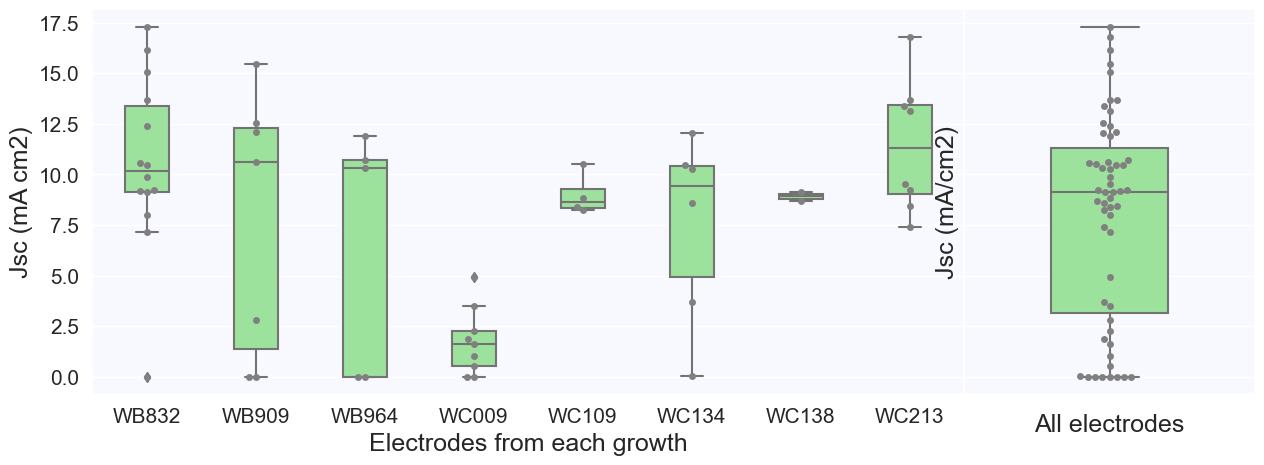

In [20]:
# Box plots for Jsc

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='Jsc (mA/cm2)', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'lightgreen', zorder=2)
sns.swarmplot(y='Jsc (mA/cm2)', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='Jsc (mA/cm2)', data=df_all, width=0.4, ax=ax[1], color='lightgreen', zorder=2)
sns.swarmplot(y='Jsc (mA/cm2)', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('Jsc (mA cm2)', size=18)
ax[0].set_xlabel('Electrodes from each growth', size=18)
ax[1].set_ylabel('Jsc (mA/cm2)', size=18)
ax[1].set_xlabel('All electrodes', size=18)

#ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

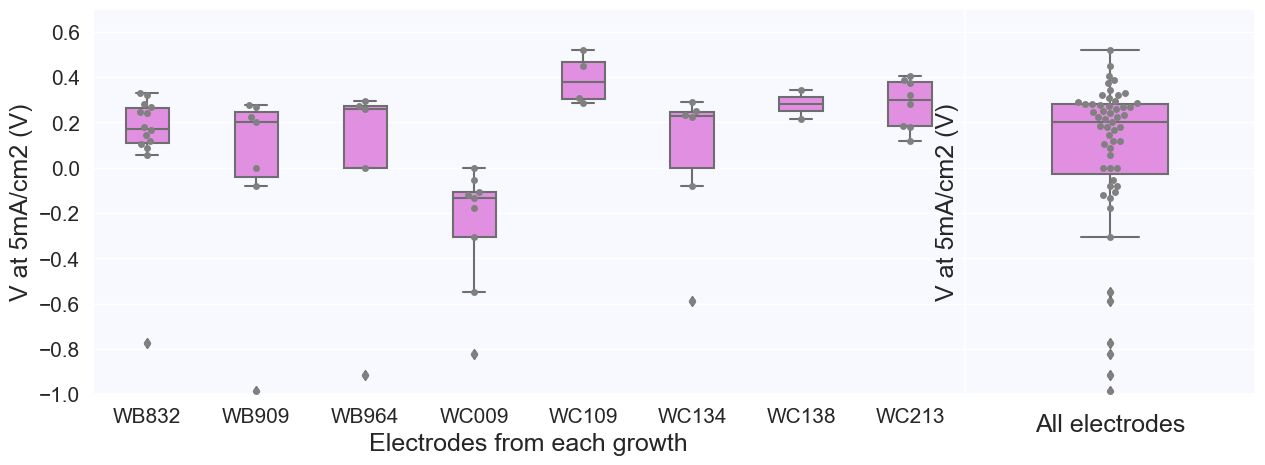

In [21]:
# Box plots for 5 mA/cm2 potential

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='V_5mA', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'violet', zorder=2)
sns.swarmplot(y='V_5mA', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='V_5mA', data=df_all, width=0.4, ax=ax[1], color='violet', zorder=2)
sns.swarmplot(y='V_5mA', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('V at 5mA/cm2 (V)', size=18)
ax[0].set_xlabel('Electrodes from each growth', size=18)
ax[1].set_ylabel('V at 5mA/cm2 (V)', size=18)
ax[1].set_xlabel('All electrodes', size=18)
#ax[2].set_ylabel('V at 5mA/cm2 (V)')

ax[0].set_ylim(-1, 0.5); ax[1].set_ylim(-1, 0.7)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

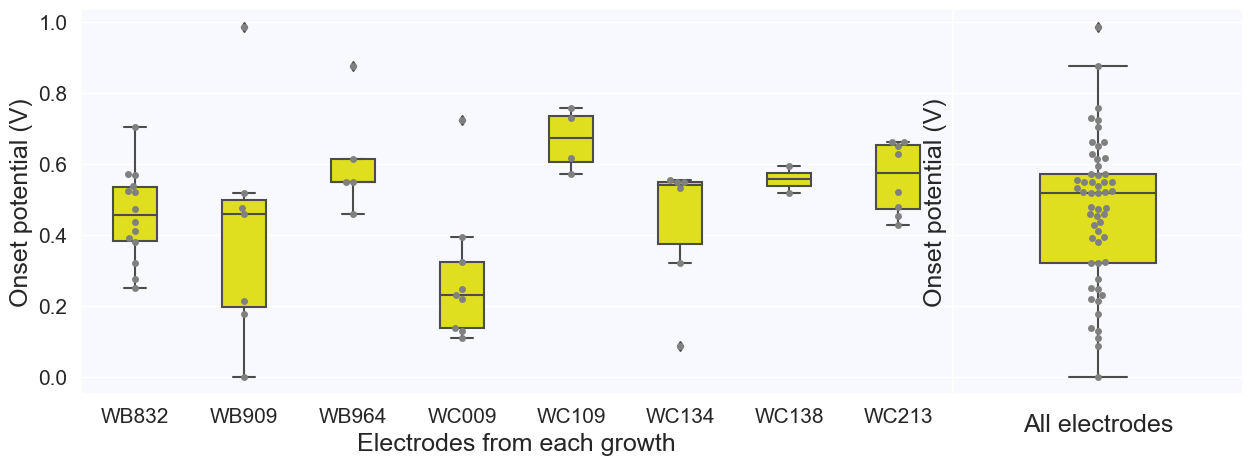

In [22]:
# Compare onset potential for each growth and all growths

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='V_onset', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'yellow', zorder=2)
sns.swarmplot(y='V_onset', data=df_all, x='Growth', ax=ax[0], size=5, color='gray')

sns.boxplot(y='V_onset', data=df_all, width=0.4, ax=ax[1], color='yellow', zorder=2)
sns.swarmplot(y='V_onset', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('Onset potential (V)', size=18)
ax[0].set_xlabel('Electrodes from each growth', size=18)
ax[1].set_ylabel('Onset potential (V)', size=18)
ax[1].set_xlabel('All electrodes', size=18)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

### Separate by growth parameters instead of growth number
* capping layer material
* capping layer thickness
* top cell base thickness/TCBT
* growth date

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/s

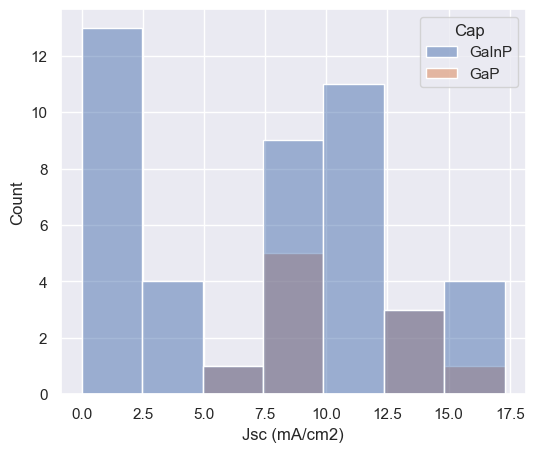

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(6,5))

sns.set_theme(color_codes=True)

#sns.boxplot(y='V_onset', data=df_all, x='Growth', width = 0.4, ax=ax[0], color = 'yellow', zorder=2)
# ax[0].hist(x=results_df['Mean'], bins=nbins)
sns.histplot(data=df_all, x='Jsc (mA/cm2)', hue="Cap") #, ax=ax[0])

#ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlabel('V_onset (V)', size=18)
#ax.set_ylabel('Count', size=18)

plt.show()

GaP shows a higher Jsc than GaInP as a capping material, but there are much fewer GaP samples than GaInP.

/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/oliviaalley/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

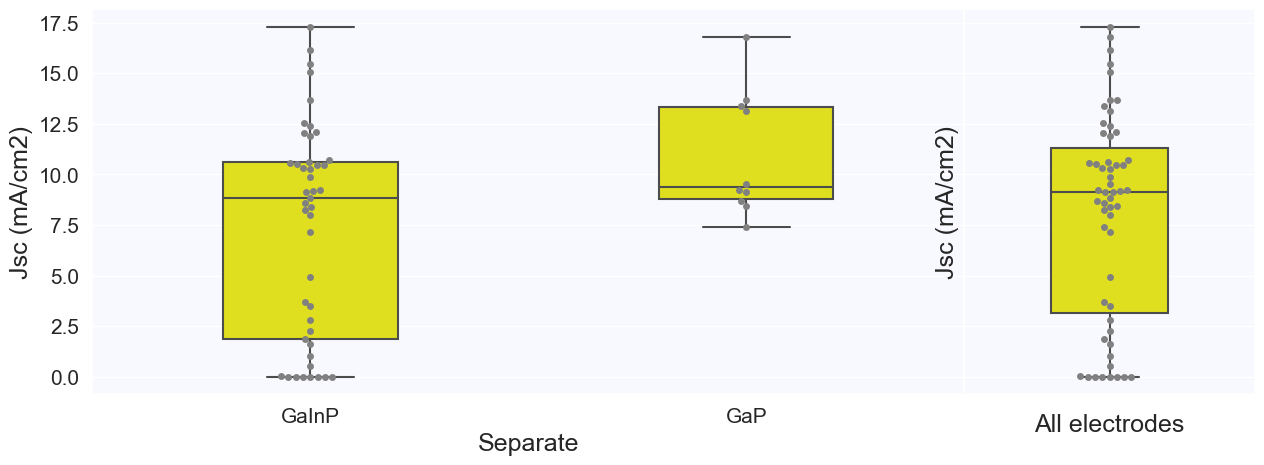

In [24]:
# Compare Jsc in a boxplot

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=100, sharey=True, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

sns.boxplot(y='Jsc (mA/cm2)', data=df_all, x='Cap', width = 0.4, ax=ax[0], color = 'yellow', zorder=2)
sns.swarmplot(y='Jsc (mA/cm2)', data=df_all, x='Cap', ax=ax[0], size=5, color='gray')

sns.boxplot(y='Jsc (mA/cm2)', data=df_all, width=0.4, ax=ax[1], color='yellow', zorder=2)
sns.swarmplot(y='Jsc (mA/cm2)', data=df_all, ax=ax[1], color='gray')

ax[0].set_ylabel('Jsc (mA/cm2)', size=18)
ax[0].set_xlabel('Separate', size=18)
ax[1].set_ylabel('Jsc (mA/cm2)', size=18)
ax[1].set_xlabel('All electrodes', size=18)

for ax in ax.flat:
    ax.set_facecolor('ghostwhite')
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.subplots_adjust(wspace=0.0, hspace=0.1)

plt.show()

## Hypothesis testing

* LSV data are from GaAs/GaInP tandem photocathodes measured in 0.5M H2SO4 in a 2 electrode format, no membrane, with a high quality Ir/IrOx CE

* Are any of the growths significantly different, according to the selected four metrics, compared to the others?  

* Experimental error itself will lead to a normally distributed error in the measurements among each growth. Edge pieces of a MOVPE grown photoelectrode are known to have more pinholes, so could be removed. However, not all failed electrodes are edge pieces, nor do all edge pieces fail. 

* So does the between-growth variance exceed the within-growth variance for any of the growths, with or without the edge pieces?  

* In this case, the null hypothesis is that all growths are from the same (normal) distribution.

* Install scipy: conda install scipy


In [27]:
# function for evaluating null hypothesis H0 against a predetermined value of α

def hypothesis_test(p, α=0.05):
    """
    Compares p against α
    print a statement as to whether null hypothesis H0 should be accepted 
      or rejected
    Note use of 'g' format specifier which switches between decimal and scientific
    """
    if p > α:
        print(f'p ({p:.3g}) > α ({α}) so accept null hypothesis H0')
    else:
         print(f'p ({p:.3g}) < α ({α}) so reject null hypothesis H0')

# Test it
hypothesis_test(0.85)

p (0.85) > α (0.05) so accept null hypothesis H0


In [28]:
df_all.head()

,Sample,Growth,Jsat (mA/cm2),Jsc (mA/cm2),V_onset,V_5mA,TCBT,Cap,Cap_nm,G_D
0,WB832-C1,WB832,16.157954,9.104689,0.274514,0.106404,0.9,GaInP,15,2021-03-10
1,WB832-C2,WB832,8.573917,0.000000,0.704958,-0.773122,0.9,GaInP,15,2021-03-10
2,WB832-C3,WB832,13.652918,7.169919,0.250526,0.057431,0.9,GaInP,15,2021-03-10
3,WB832-C4,WB832,14.090213,9.204426,0.320490,0.116999,0.9,GaInP,15,2021-03-10
4,WB832-C5,WB832,13.410872,10.437638,0.412439,0.179965,0.9,GaInP,15,2021-03-10


## t-tests

In [29]:
# Do a t-test using function from scipy
from scipy.stats import ttest_ind

# Compare WC009, which was low performing, with all growths that are not WC009.
# null hypothesis for t test is that WC009 is from the same distribution.
#level1 = 'WB832'
level2 = 'WC009'
#metric = 'Jsc (mA/cm2)'
#metric = 'V_5mA'
#metric = 'Jsat (mA/cm2)'
metric = 'Jsc (mA/cm2)'

#cat1 = df_all[df_all['Growth']==level1]
cat1 = df_all[df_all['Growth']==level2]
#print(cat1.describe())
cat2 = df_all[df_all['Growth']!=level2]
#print(cat2.describe())

#print(cat2[metric])

model = ttest_ind(cat1[metric], cat2[metric])
hypothesis_test(model.pvalue)
print()
model

p (1.54e-05) < α (0.05) so reject null hypothesis H0



TtestResult(statistic=-4.760147728535134, pvalue=1.5352838814387624e-05, df=53.0)

> WC009 has a significantly different onset potential than the other electrodes.

In [31]:
# Compare Jsc of WB832 with that of WB909
# null hypothesis for t test is that they are from the same distribution.
level1 = 'WB832'
level2 = 'WB909'
metric = 'V_onset'

cat1 = df_all[df_all['Growth']==level1]
#print(cat1.describe())
cat2 = df_all[df_all['Growth']==level2]
#print(cat2.describe())

model = ttest_ind(cat1[metric], cat2[metric])
hypothesis_test(model.pvalue)
print()
model

p (0.605) > α (0.05) so accept null hypothesis H0



Ttest_indResult(statistic=0.52588531561026, pvalue=0.6050523232198464)

> WB832 and WB909 have statistically the same distribution of onset potentials.

In [30]:
# When doing multiple t tests on the same sample, like WC009 here, need to have a smaller
# value for rejecting the null hypothesis because of the additive effect over multiple comparisons.
# Rather than p < 0.05, which has a 5% chance of giving erronious results, it should be 5%/8,
# where 8 is the number of samples (here, number of growths)

levels = df_all.Growth.unique()
levels
for lev_ in levels:
    df_all_one = df_all[df_all.Growth==lev_][['Growth',metric]].reset_index(drop=True) 
    df_all_rest = df_all[df_all.Growth!=lev_][['Growth',metric]].reset_index(drop=True)
    print(lev_, df_all_one.shape[0],df_all_rest.shape[0], ttest_ind(df_all_one[metric],
                                                    df_all_rest[metric], alternative='two-sided'))
    

WB832 14 41 TtestResult(statistic=2.2566809822575866, pvalue=0.02817606955120411, df=53.0)
WB909 7 48 TtestResult(statistic=-0.20168403175451993, pvalue=0.8409358572192095, df=53.0)
WB964 5 50 TtestResult(statistic=-0.6512087198594837, pvalue=0.5177254568367311, df=53.0)
WC009 9 46 TtestResult(statistic=-4.760147728535134, pvalue=1.5352838814387624e-05, df=53.0)
WC109 4 51 TtestResult(statistic=0.3957585135933495, pvalue=0.6938718393412422, df=53.0)
WC134 6 49 TtestResult(statistic=-0.2519923182021553, pvalue=0.8020216366225703, df=53.0)
WC138 2 53 TtestResult(statistic=0.2517919252686975, pvalue=0.8021757160114115, df=53.0)
WC213 8 47 TtestResult(statistic=2.1192600580838246, pvalue=0.03877094185897717, df=53.0)


In [44]:
0.05/8

0.00625

#### WC009 is the only growth that is significantly different from the other growths.

## ANOVA

In [33]:
import statsmodels.api as sm

from statsmodels.formula.api import ols

# ANOVA on the entire data set
model = ols('V_5mA ~ C(Growth, Sum)', df_all).fit()
hypothesis_test(model.f_pvalue)
print()
model.summary()

p (0.0147) < α (0.05) so reject null hypothesis H0



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  V_5mA   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     2.847
Date:                Thu, 16 Nov 2023   Prob (F-statistic):             0.0147
Time:                        12:31:25   Log-Likelihood:                -9.4636
No. Observations:                  55   AIC:                             34.93
Df Residuals:                      47   BIC:                             50.99
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1066      0.049      2.191      0.033       0.009       0.204
C(Growth, Sum)[S.WB832]     0.0202      0.087      0.232      0.817      -0.155       0.195
C(Growth, Sum)[S.WB909]    -0.1200      0.113     -1.063      0.293      -0.347       0.107
C(Growth, Sum)[S.WB964]    -0.1243      0.130     -0.957      0.343      -0.386       0.137
C(Growth, Sum)[S.WC009]    -0.3586      0.102     -3.513      0.001      -0.564      -0.153
C(Growth, Sum)[S.WC109]     0.2839      0.143      1.983      0.053      -0.004       0.572
C(Growth, Sum)[S.WC134]    -0.0515      0.120     -0.428      0.671      -0.293       0.190
C(Growth, Sum)[S.WC138]     0.1748      0.197      0.889      0.378      -0.221       0.570
==============================================================================
Omnibus:                       34.122   Durbin-Watson:                   2.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.709
Skew:                          -2.007   Prob(JB):                     7.29e-16
Kurtosis:                       6.782   Cond. No.                         5.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA DataFrame
print(table)

                  sum_sq    df        F    PR(>F)
C(Growth, Sum)  1.960349   7.0  2.80376  0.016445
Residual        4.494765  45.0      NaN       NaN


In [38]:
model2 = ols('V_5mA ~ Growth', df_all).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  V_5mA   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     2.804
Date:                Sat, 04 Nov 2023   Prob (F-statistic):             0.0164
Time:                        12:43:36   Log-Likelihood:                -9.8182
No. Observations:                  53   AIC:                             35.64
Df Residuals:                      45   BIC:                             51.40
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1268      0.084      1.501      0.140      -0.043       0.297
Growth[T.WB909]    -0.1401      0.146     -0.958      0.343      -0.435       0.155
Growth[T.WB964]    -0.1445      0.165     -0.878      0.385      -0.476       0.187
Growth[T.WC009]    -0.3788      0.135     -2.805      0.007      -0.651      -0.107
Growth[T.WC109]     0.2637      0.179      1.472      0.148      -0.097       0.625
Growth[T.WC134]    -0.0716      0.154     -0.464      0.645      -0.382       0.239
Growth[T.WC138]     0.1546      0.239      0.647      0.521      -0.327       0.636
Growth[T.WC213]     0.1993      0.154      1.292      0.203      -0.111       0.510
==============================================================================
Omnibus:                       33.008   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.213
Skew:                          -2.002   Prob(JB):                     6.91e-15
Kurtosis:                       6.674   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

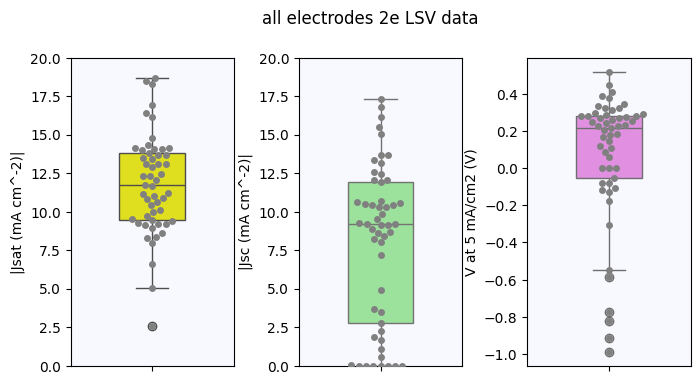


current density at short circuit vs. Ir/IrOx CE (mA/cm2):
median:   9.16
mean:     8.01
std dev:  5.21


In [79]:
# Now graph Jsat, Jsc, and 5 mA potential for all the electrodes
#use a dataframe to store results

## there were strange deprecation errors ignore them
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

sample =  []
Jsat = []
Jzero = []
V_5mA = []

for dic in exp_list:
    sample.append(dic['sample'])
    Jsat.append(np.abs(dic['Jsat (mA/cm2)']))
    Jzero.append(np.abs(dic['zero bias']))
    V_5mA.append(float(dic['5 mA potential']))

# Use a dictionary to associate the lists with the column headers
df_JWA = pd.DataFrame({'sample': sample,
                       'Jsat (mA/cm2)': Jsat,
                       'Jzero': Jzero,
                       'V_5mA': V_5mA}) 

# Fancy, write the samples in the title
temp_str = '  '.join(exp['sample'] for exp in exp_list)

fig, ax = plt.subplots(1,3, dpi=100, figsize=(8,4))
fig.suptitle('all electrodes 2e LSV data', y = 1.0)
#fig.suptitle('OA LSV data\n'
#             f'Samples: {temp_str}', y=1.0)

sns.boxplot(y='Jsat (mA/cm2)', data=df_all, width=0.4, ax=ax[0], color='yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=df_all, ax=ax[0], color='gray')


#sns.boxplot(y='Jsat (mA/cm2)', data=df_all, x='growth')

sns.boxplot(y="Jsc (mA/cm2)", data=df_all, width=0.4, ax=ax[1], color='lightgreen', zorder=2)
sns.swarmplot(y="Jsc (mA/cm2)", data=df_all, ax=ax[1], color='gray')

sns.boxplot(y="V_5mA (V)", data=df_all, width=0.4, ax=ax[2], color='violet', zorder=2)
sns.swarmplot(y="V_5mA (V)", data=df_all, ax=ax[2], color='gray')

ax[0].set_ylabel('|Jsat (mA cm^-2)|')
ax[1].set_ylabel('|Jsc (mA cm^-2)|')
ax[2].set_ylabel('V at 5 mA/cm2 (V)')

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20) 


for ax in ax.flat:
    ax.set_facecolor('ghostwhite')

fig.subplots_adjust(wspace=0.4, hspace=0.1)

plt.show()

# Statistics
print('\ncurrent density at short circuit vs. Ir/IrOx CE (mA/cm2):')
print(f'median:  {df_all["Jsc (mA/cm2)"].median():>5.2f}')
print(f'mean:    {df_all["Jsc (mA/cm2)"].mean():>5.2f}')
print(f'std dev: {df_all["Jsc (mA/cm2)"].std():>5.2f}')

In [46]:
# Compare with Jsat, Jsc, and 5 mA potential for individual growths

## there were strange deprecation errors ignore them
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

growth = []
sample =  []
Jsat = []
Jzero = []
V_5mA = []

for dic in exp_list:
    growth.append(dic['growth'])
    sample.append(dic['sample'])
    Jsat.append(np.abs(dic['Jsat (mA/cm2)']))
    Jzero.append(np.abs(dic['zero bias']))
    V_5mA.append(float(dic['5 mA potential']))

# Use a dictionary to associate the lists with the column headers
df_OA = pd.DataFrame({'growth': growth, 
                      'sample': sample,
                       'Jsat (mA/cm2)': Jsat,
                       'Jzero': Jzero,
                       'V_5mA': V_5mA}) 

#first_df = df[df['J (mA/cm2)']<-5]
temp_df = df_OA[df_OA['growth'] == 'WB832']

df_OA.head()
temp_df



,growth,sample,Jsat (mA/cm2),Jzero,V_5mA
0,WB832,WB832-C1,16.157954,9.104689,0.106404
1,WB832,WB832-C2,8.573917,0.000000,-0.773122
2,WB832,WB832-C3,13.652918,7.169919,0.057431
3,WB832,WB832-C4,14.090213,9.204426,0.116999
4,WB832,WB832-C5,13.410872,10.437638,0.179965
5,WB832,WB832-C6,13.803464,9.862762,0.142985
6,WB832,WB832-C7,13.112378,10.556487,0.166372
7,WB832,WB832-C8,12.873657,8.012504,0.088714
8,WB832,WB832-C9,14.010306,13.677530,0.321288
9,WB832,WB832-NREL2,18.260145,17.292124,0.331283


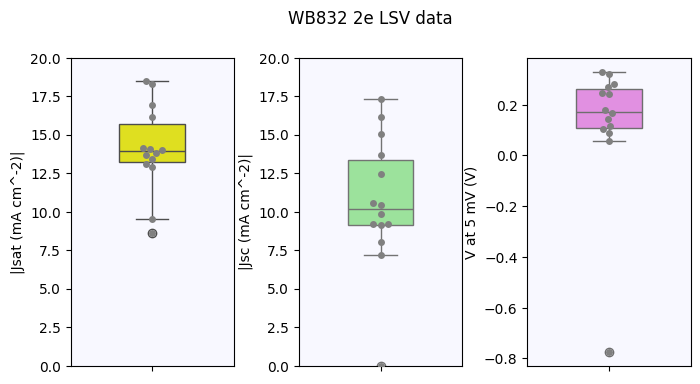

J at 0 vs CE (mA/cm2)
median:  10.15
mean:    10.58
std dev:  4.35


In [47]:


# Fancy, write the samples in the title
temp_str = '  '.join(exp['sample'] for exp in exp_list)

fig, ax = plt.subplots(1,3, dpi=100, figsize=(8,4))
fig.suptitle('WB832 2e LSV data', y = 1.0)
#fig.suptitle('OA LSV data\n'
#             f'Samples: {temp_str}', y=1.0)

sns.boxplot(y='Jsat (mA/cm2)', data=temp_df, width=0.4, ax=ax[0], color='yellow', zorder=2)
sns.swarmplot(y='Jsat (mA/cm2)', data=temp_df, ax=ax[0], color='gray')

sns.boxplot(y="Jzero", data=temp_df, width=0.4, ax=ax[1], color='lightgreen', zorder=2)
sns.swarmplot(y="Jzero", data=temp_df, ax=ax[1], color='gray')

sns.boxplot(y="V_5mA", data=temp_df, width=0.4, ax=ax[2], color='violet', zorder=2)
sns.swarmplot(y="V_5mA", data=temp_df, ax=ax[2], color='gray')

ax[0].set_ylabel('|Jsat (mA cm^-2)|')
ax[1].set_ylabel('|Jsc (mA cm^-2)|')
ax[2].set_ylabel('V at 5 mV (V)')

ax[0].set_ylim(0, 20); ax[1].set_ylim(0, 20) 


for ax in ax.flat:
    ax.set_facecolor('ghostwhite')

fig.subplots_adjust(wspace=0.4, hspace=0.1)

plt.show()

# Statistics
print('J at 0 vs CE (mA/cm2)')
print(f'median:  {temp_df["Jzero"].median():>5.2f}')
print(f'mean:    {temp_df["Jzero"].mean():>5.2f}')
print(f'std dev: {temp_df["Jzero"].std():>5.2f}')